In [1]:

import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive,HMC
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax

from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)

from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from numpyro.distributions.truncated import TruncatedDistribution
from numpyro.distributions import (
    Distribution,
    constraints)
from numpyro.distributions.util import is_prng_key, promote_shapes, validate_sample
from jax import lax
from SkewNormalPlus import SkewNormalPlus

/home/bmb41/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

@jit
def minmax_fit_and_scale(X):
  max= jnp.max(X,axis=0)
  min = jnp.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min

from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun

rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=20,B=3),)*5),prior=Normal())

_, log_pdf_flow, sample_flow = init_fun(flow_rng,2 )



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
file = jnp.load('flow2d2.npz',allow_pickle=True)
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)

opt_params = pickle.load(open('flow2d_opt2.pkl', "rb"))
opt_state = optimizers.pack_optimizer_state(opt_params)

params = get_params(opt_state)



min_file = jnp.asarray(file['min'])
max_file = jnp.asarray(file['max'])
diff_scale = jnp.log(max_file[0]-min_file[0])

class FlowSNP(Distribution):
    arg_constraints = {"m_int": constraints.real, "sigma_int": constraints.real,"m_cut": constraints.real, "sigma_cut": constraints.real}
    support = constraints.real
    reparametrized_params = ["m_int", "sigma_int","m_cut","sigma_cut"]

    def __init__(self,m_int,sigma_int,m_cut,sigma_cut,*, validate_args=None,res=1000):


        self.min = min_file
        self.max = max_file




        self.m_int, self.sigma_int,self.m_cut,self.sigma_cut = promote_shapes(m_int,sigma_int,m_cut,sigma_cut)


        batch_shape = lax.broadcast_shapes(jnp.shape(m_int), jnp.shape(sigma_int),jnp.shape(m_int), jnp.shape(sigma_int))

        n_obj = m_int.shape[0]


        self.n_obj=n_obj



        super(FlowSNP, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )


    def sample(self,key, sample_shape=()):
        assert is_prng_key(key)



        no_samps = sample_shape[0]

        self.no_samps = no_samps

        m_col =  jnp.repeat(self.m_int.reshape(self.n_obj),no_samps).reshape(no_samps*self.n_obj,1)

        theta = jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_samps*self.n_obj).reshape(no_samps*self.n_obj,1)))



        samp=sample_flow(key, params,minmax_scale(theta,jnp.asarray(self.min[1:]),np.asarray(self.max[1:])),num_samples=self.no_samps*self.n_obj)

        samp = minmax_unscale(samp[:,0],self.min[0],self.max[0]).reshape(no_samps*self.n_obj,1) + m_col



        return samp.reshape(self.n_obj,self.no_samps).T


    @jax.jit
    def log_prob(self, value):

        no_samps = 1
        no_obj = value.shape[0]


        value=value.T.reshape(no_samps*no_obj,)
        value = value.reshape(no_samps*no_obj,1)


        m_col = self.m_int.reshape(no_obj,1)

        theta=jnp.column_stack((m_col,jnp.repeat(self.sigma_int,no_obj).reshape(no_obj,1)))

        theta = jnp.repeat(theta,no_samps,axis=0)

        value = value -theta[:,:1]

        X=jnp.asarray(minmax_scale(jnp.column_stack((value,theta)),min_file,max_file))


        prob = log_pdf_flow(params,X)
        prob = prob.reshape(no_obj*no_samps,)
        prob=prob.reshape(no_obj,no_samps).T - diff_scale


        return prob 




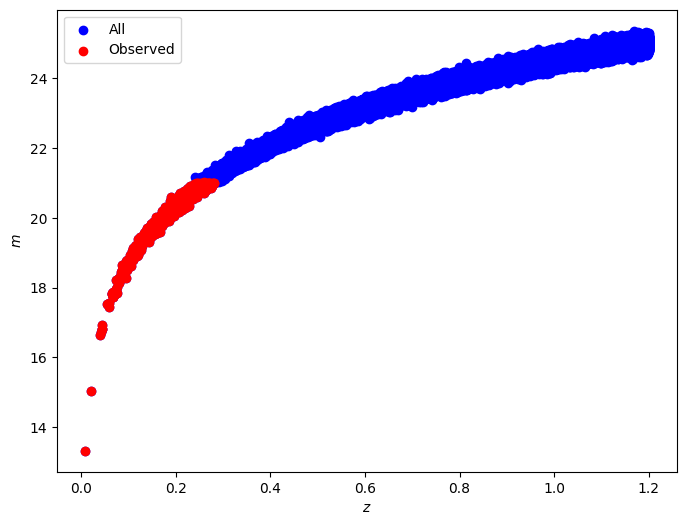

1045


In [4]:


import numpy as np
from matplotlib import pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from jax import random
import jax

from jax.scipy.stats import norm
from jax.scipy.special import ndtri
#assert numpyro.__version__.startswith("0.11.0")

numpyro.set_host_device_count(4)
jax.config.update('jax_enable_x64',True)


import jax_cosmo as jc
from jax_cosmo import Cosmology, background

from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.coordinates import Distance

from numpyro import sample

import numpyro.distributions as dist

import jax.numpy as jnp

from numpyro.distributions.truncated import TruncatedDistribution 

from SkewNormalPlus import SkewNormalPlus

def sample_model(z_s,mag_s=None,sel_s=None,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1,mu_cut=21,sigma_cut=0.01):

    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=mag_s)
        
        p_s=norm.cdf(-m_s,loc=-mu_cut,scale=sigma_cut)
        
        sel_s=numpyro.sample("sel_s",dist.Bernoulli(p_s),obs=sel_s)
        


def model_flat(z_s,m_s=None,sel_s=None,h=0.7324,w=-1,mu_cut=21,sigma_cut=0.01):

    
    M0=numpyro.sample('M0', dist.ImproperUniform(dist.constraints.real,(),event_shape=()))
    #sigma_int = numpyro.sample("sigma_int", dist.HalfCauchy(1))
    sigma_int = 0.1
    Om0=numpyro.sample('Om0',dist.Uniform(0,1))
    
    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_0 = M0 + mu_s
        
        m_s=numpyro.sample("m_s", FlowSNP(m_int=m_0, sigma_int=sigma_int,
                                                 m_cut=mu_cut,sigma_cut=sigma_cut), obs=m_s)
        
  

        
def naive_sample_model(z_s,mag_s=None,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1):

    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=mag_s)
        
        
        
def naive_model_flat(z_s,m_s=None,h=0.7324,w=-1):

    
    M0=numpyro.sample('M0', dist.ImproperUniform(dist.constraints.real,(),event_shape=()))
    sigma_int = numpyro.sample("sigma_int", dist.HalfCauchy(1))
    Om0=numpyro.sample('Om0',dist.Uniform(0,1))
    
    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    
    n_sne=len(z_s)
    
    with numpyro.plate("plate_i",n_sne):
        
        
        d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))
    
        mu_s=5*jnp.log10((1+z_s)/h*d_s*1e6/10)
        
        m_s=numpyro.sample("m_s", dist.Normal(M0+mu_s, sigma_int), obs=m_s)
        


        
u=np.random.rand(100000)

z_s=jnp.asarray((3*u)**(1/3)/(3)**(1/3)*1.2)

seed=1701

rng_key = jax.random.PRNGKey(seed)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(sample_model, num_samples=1)
prior_predictions = prior_predictive(rng_key_,z_s)

m_sim = prior_predictions["m_s"][0,:]
sel_sim = prior_predictions["sel_s"][0,:]

plt.figure(figsize=(8,6))
plt.scatter(z_s,m_sim,color='blue',label='All')
plt.scatter(z_s[sel_sim==1],m_sim[sel_sim==1],color='red',label='Observed')
plt.ylabel('$m$')
plt.xlabel('$z$')
plt.legend()
plt.show()
print(len(m_sim[sel_sim==1]))






In [6]:
#nuts_kernel = NUTS(model_flat,adapt_step_size=True)
#nuts_kernel = NUTS(model_flat,adapt_step_size=True)

rw=RandomWalkMetropolis(model=model_flat)
mcmc = MCMC(rw, num_samples=10000, num_warmup=10000,num_chains=4)
rng_key = random.PRNGKey(0)
#mcmc.run(rng_key, z_s,m_s= m_sim)




#mcmc.run(rng_key, z_s[sel_sim==1.],m_s= m_sim[sel_sim==1.],sel_s=sel_sim[sel_sim==1.])


mcmc.run(rng_key, z_s[sel_sim==1.],m_s= m_sim[sel_sim==1.])


Compiling.. :   0%|                                   | 0/20000 [00:00<?, ?it/s]

  0%|                                                 | 0/20000 [00:00<?, ?it/s]

Compiling.. :   0%|                                   | 0/20000 [00:00<?, ?it/s]


  0%|                                                 | 0/20000 [00:00<?, ?it/s]


Compiling.. :   0%|                                   | 0/20000 [00:00<?, ?it/s]

Running chain 1:   0%|                                | 0/20000 [00:39<?, ?it/s]


Running chain 3:   0%|                                | 0/20000 [00:39<?, ?it/s]


Running chain 1:   5%|▉                  | 1000/20000 [11:25<3:24:30,  1.55it/s]

Running chain 1:  10%|█▉                 | 2000/20000 [22:11<3:13:53,  1.55it/s]

Running chain 2:  10%|█▉                 | 2000/20000 [22:12<3:13:54,  1.55it/s]


Running chain 1:  15%|██▊                | 3000/20000 [33:00<3:03:22,  1.55it/s]


Running chain 0:  15%|██▊                | 3000/20000 [33:03<3:03:40,  1.54it/s]

Running ch

In [ ]:
import corner
mcmc.print_summary()
posterior_samples = mcmc.get_samples()
a=['M0', 'Om0']


samps=np.zeros((len(a),4000))

for i in range(len(a)):
    samps[i,:]=posterior_samples[a[i]]


corner.corner(samps.T,labels=a,truths=[-19.5,0.28])
plt.show()

In [ ]:
plt.plot(posterior_samples['M0'].reshape(4,1000).T)

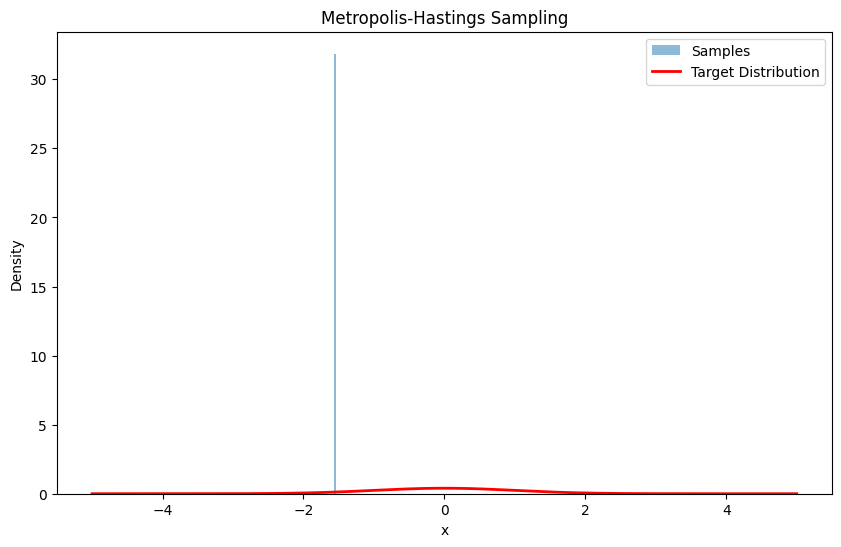

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution (1D Gaussian)
def target_distribution(x):
    return jnp.exp(-0.5 * x**2) / jnp.sqrt(2 * jnp.pi)

# Metropolis-Hastings algorithm
def metropolis_hastings(target_dist, proposal_dist, num_samples, initial_state, step_size):
    samples = [initial_state]
    current_state = initial_state

    for _ in range(num_samples):
        # Propose a new state
        proposed_state = current_state + jax.random.normal(jax.random.PRNGKey(0)) * step_size

        # Calculate acceptance ratio
        acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)

        # Accept or reject the proposed state
        if jax.random.uniform(jax.random.PRNGKey(0)) < acceptance_ratio:
            current_state = proposed_state

        samples.append(current_state)

    return jnp.array(samples)

# Parameters
num_samples = 10000
initial_state = 0.0
step_size = 1

# Run Metropolis-Hastings
samples = metropolis_hastings(target_distribution, jax.random.normal, num_samples, initial_state, step_size)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.5, label='Samples')
x = jnp.linspace(-5, 5, 1000)
plt.plot(x, target_distribution(x), 'r-', linewidth=2, label='Target Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Metropolis-Hastings Sampling')
plt.show()


[ 0.         -0.39238289 -0.78476578 ... -3.92382888 -3.92382888
 -3.92382888]
